# SPGR

In [1]:
import version_control

Last run on cashlab03-deb at 2015-04-28 15:56:37.573382

Phypno Version: 5fd34bdecf40bf72accfd82aba7495eba94acafb

Babel==1.3, Cython==0.22, Jinja2==2.7.3, Markdown==2.6.2, MarkupSafe==0.23, Pillow==2.8.1, PyOpenGL==3.1.0, Pygments==2.0.2, Sphinx==1.3.1, alabaster==0.7.3, bash-kernel==0.3, beautifulsoup4==4.3.2, biopython==1.65, certifi==2015.04.28, coverage==3.7.1, decorator==3.4.2, docutils==0.12, easydev==0.8.3, ipython==3.1.0, jedi==0.9.0, jsonschema==2.4.0, matplotlib==1.4.3, memory-profiler==0.32, mistune==0.5.1, networkx==1.9.1, nibabel==2.0.0, nitime==0.5, nltk==3.0.2, nose==1.3.6, numpy==1.9.2, numpydoc==0.5, ordereddict==1.1, pandas==0.16.0, pandocfilters==1.2.4, pep8==1.6.2, pexpect==3.3, pockets==0.2.4, psutil==2.2.1, pycurl==7.19.5.1, pyflakes==0.8.1, pyparsing==2.0.3, pyqtgraph==0.9.10, python-dateutil==2.4.2, python-igraph==0.7.1-4, pytz==2015.2, pyzmq==14.6.0, requests==2.6.2, rope-py3k==0.9.4-1, rpy2==2.5.6, scikit-learn==0.16.1, scipy==0.15.1, six==1.9.0, snowballstem

## Spindle Properties: Statistics

### Frequency Direction (subset of regions)

In [171]:
good_regions = ['caudalmiddlefrontal',
                'insula',
                'lateralorbitofrontal',
                'medialorbitofrontal',
                'parsopercularis',
                'parsorbitalis',
                'parstriangularis',
                'postcentral',
                'precentral',
                'rostralmiddlefrontal',
                'superiorfrontal',
                'superiorparietal',
                'supramarginal',
                ]

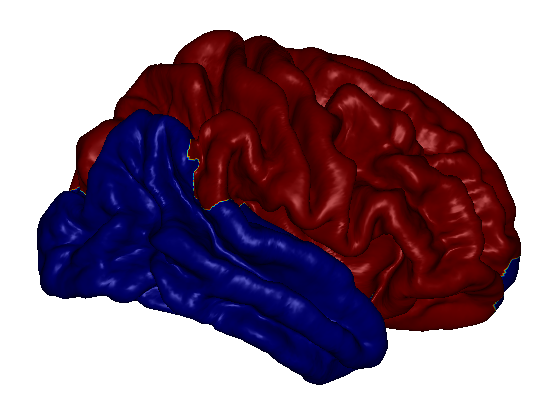

In [262]:
val = zeros(label[0].shape)
for one_region in label[2]:
    if one_region in good_regions:
        val[array(label[0]) == label[2].index(one_region)] = 1

v = Viz3()
v.add_surf(surf, values=val, limits_c=(0, 1))
v._canvas.DrawNow()
screenshot(join(OUTPUT_DIR, 'freq_selectedregions.png'), v._viewbox, sf=2)
v

In [267]:
df_raw = []

for subj, one_dat, one_channel in zip(all_subj, all_freq, all_chan):
    for one_chan in one_dat.axis['chan'][0]:
        region = one_channel.return_attr('region', (one_chan, ))[0]
        x = one_channel.return_xyz((one_chan, ))[0, 0]
        y = one_channel.return_xyz((one_chan, ))[0, 1]
        z = one_channel.return_xyz((one_chan, ))[0, 2]
        value = one_dat(trial=0, chan=one_chan)
        
        if region[:3] == 'ctx' and region[7:] in good_regions:
    
            df_raw.append({'subj': subj,
                           'xpos': x,
                           'ypos': y,
                           'zpos': z,
                           'elec': one_chan,
                           'value': value})

In [268]:
df = DataFrame(df_raw)

In [299]:
%%R -i df -o tstat -o regions -o pvalues
options(contrasts=c('contr.sum', 'contr.poly'))
df$value <-  as.numeric(levels(df$value))[df$value]

lm1 <- lmer(value ~ 1 + xpos * ypos * zpos + (1|subj), df)
print(summary(lm1))

coefs <- data.frame(coef(summary(lm1)))
coefs$p.value <- 2 * (1 - pnorm(abs(coefs$t.value)))
coefs

Linear mixed model fit by REML ['lmerMod']
Formula: value ~ 1 + xpos * ypos * zpos + (1 | subj)
   Data: df

REML criterion at convergence: 673.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6884 -0.5244 -0.0561  0.4604  3.2856 

Random effects:
 Groups   Name        Variance Std.Dev.
 subj     (Intercept) 0.4420   0.6648  
 Residual             0.4995   0.7067  
Number of obs: 257, groups:  subj, 6

Fixed effects:
                    Estimate    Std. Error t value
(Intercept)    11.5234174029  0.2970384610   38.79
xpos           -0.0005369189  0.0034618050   -0.16
ypos            0.0110067237  0.0033618127    3.27
zpos            0.0220548735  0.0031550582    6.99
xpos:ypos      -0.0001213701  0.0000758976   -1.60
xpos:zpos       0.0000522103  0.0000718939    0.73
ypos:zpos      -0.0002674097  0.0000803447   -3.33
xpos:ypos:zpos  0.0000004973  0.0000020850    0.24

Correlation of Fixed Effects:
            (Intr) xpos   ypos   zpos   xps:yp xps:zp yps:zp
xpos       

In [316]:
%%R -i df -o tstat -o regions -o pvalues
options(contrasts=c('contr.sum', 'contr.poly'))
df$value <-  as.numeric(levels(df$value))[df$value]

lm1 <- lmer(value ~ 1 + ypos * zpos + (1|subj), df)
print(summary(lm1))

Linear mixed model fit by REML ['lmerMod']
Formula: value ~ 1 + ypos * zpos + (1 | subj)
   Data: df

REML criterion at convergence: 615

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7988 -0.6067 -0.0835  0.5093  3.3547 

Random effects:
 Groups   Name        Variance Std.Dev.
 subj     (Intercept) 0.4282   0.6544  
 Residual             0.5154   0.7179  
Number of obs: 257, groups:  subj, 6

Fixed effects:
               Estimate  Std. Error t value
(Intercept) 11.47166771  0.29169353   39.33
ypos         0.00863623  0.00323763    2.67
zpos         0.02260621  0.00301843    7.49
ypos:zpos   -0.00021889  0.00007653   -2.86

Correlation of Fixed Effects:
          (Intr) ypos   zpos  
ypos      -0.226              
zpos      -0.360  0.491       
ypos:zpos  0.171 -0.834 -0.307


In [317]:
%%R
print(min(df$ypos))
print(max(df$ypos))

print(min(df$zpos))
print(max(df$zpos))

[1] -69.57
[1] 70.82
[1] -8.888
[1] 76.52


In [318]:
%%R -o newdat
newdat <- expand.grid(ypos=seq(-70, 70), zpos=seq(-8, 76), value=0)

mm <- model.matrix(terms(lm1), newdat)
newdat$value <- mm %*% fixef(lm1)

In [319]:
A = newdat[2]
A.shape = 85, 141

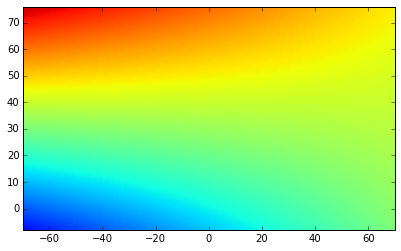

In [321]:
%matplotlib inline
from matplotlib.pyplot import savefig, imshow
imshow(squeeze(A), origin='lower', extent=(-70, 70, -8, 76), vmin=10, vmax=14) 
savefig(join(OUTPUT_DIR, 'freq_linearchanges.png'))